<h1 style="font-size:40px;"><center>Exercise IV:<br> Recurrent Neural Networks
</center></h1>

## Short summary
In this exercise, we will design a recurrent network to predict future rgb images. These folder has **three files**: 
- **configPredictor.py:** this involves definitions of all parameters and data paths
- **utilsPredictor.py:** includes utility functions required to grab and visualize data 
- **runPredictor.ipynb:** contains the script to design, train and test the network 

Make sure that before running this script, you created an environment and **installed all required libraries** such 
as keras.

## The data
There exists also a subfolder called **data** which contains the traning, validation, and testing data each has both RGB input images together with the corresponding ground truth images.


## The exercises
As for the previous lab all exercises are found below.


## The different 'Cells'
This notebook contains several cells with python code, together with the markdown cells (like this one) with only text. Each of the cells with python code has a "header" markdown cell with information about the code. The table below provides a short overview of the code cells. 

| #  |  CellName | CellType | Comment |
| :--- | :-------- | :-------- | :------- |
| 1 | Init | Needed | Sets up the environment|
| 2 | Ex | Exercise 1| A class definition of a network model  |
| 3 | Loading | Needed | Loading parameters and initializing the model |
| 4 | Stats | Needed | Show data distribution | 
| 5 | Data | Needed | Generating the data batches |
| 6 | Debug | Needed | Debugging the data |
| 7 | Device | Needed | Selecting CPU/GPU |
| 8 | Optimization | Exercise 2 | Selecting an optimization method |
| 9 | Training | Exercise 1-2 | Training the model   |
| 10 | Testing | Exercise 1-2| Testing the  method   | 
| 11 | Plotting | Information  | View some of test samples | 


In order for you to start with the exercise you need to run all cells. It is important that you do this in the correct order, starting from the top and continuing with the next cells. Later when you have started to work with the notebook it may be easier to use the command "Run All" found in the "Cell" dropdown menu.

## Writing the report

There is no need to provide any report. However, implemented network architecuture and observed experimental results must be presented as a short presentation in the last lecture, May 28.

1) We first start with importing all required modules

In [1]:
import os
from configPredictor import *
cfg = flying_objects_config()
if cfg.GPU >=0:
    print("creating network model using gpu " + str(cfg.GPU))
    os.environ['CUDA_VISIBLE_DEVICES'] = str(cfg.GPU)
elif cfg.GPU >=-1:
    print("creating network model using cpu ")  
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf
from tensorflow import keras 
from utilsPredictor import *
from sklearn.metrics import confusion_matrix
import seaborn as sns
from datetime import datetime
import pprint

# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv3D, Conv2D, Conv1D, Convolution2D, Deconvolution2D, Cropping2D, UpSampling2D
from keras.layers import Input,  Conv2DTranspose, ConvLSTM2D, TimeDistributed
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.regularizers import l2
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout


creating network model using gpu 0


2) Here, we have the network model class definition. In this class, the most important function is the one called **create_model()**. As defined in the exercises section, your task is to update the network architecture defined in this function such that the network will return the highest accuracy for the given training, validation, and testing data.

In [2]:
class PredictorDNNModel():
    def __init__(self, batch_size=32, inputShape=(64,64,3), dropout_prob=0.25): 
        self.batch_size = batch_size
        self.inputShape = inputShape
        self.dropout_prob = dropout_prob
 
    def create_model(self):

        inputs = Input(shape=self.inputShape) 
        down = ConvLSTM2D(filters=5, kernel_size=(1, 1),
                       padding='same', return_sequences=True)(inputs) 
  
        final = Conv3D(filters=3, kernel_size=(1, 1, 3),
               activation='sigmoid', padding='same', data_format='channels_last')(down)
  
        model = Model(inputs=inputs, outputs=final)
        model.summary()untitled
        return model

3) We import the network **hyperparameters** and build a simple network by calling the class introduced in the previous step. Please note that to change the hyperparameters, you just need to change the values in the file called **configPredictor.py.**

In [3]:
image_shape = (cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH, cfg.IMAGE_CHANNEL)
input_shape = (int(cfg.SEQUENCE_LENGTH/2), cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH, cfg.IMAGE_CHANNEL)
modelObj = PredictorDNNModel(batch_size=cfg.BATCH_SIZE, inputShape=input_shape, dropout_prob=cfg.DROPOUT_PROB)
model = modelObj.create_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 32, 32, 3)]    0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 5, 32, 32, 5)      180       
_________________________________________________________________
conv3d (Conv3D)              (None, 5, 32, 32, 3)      48        
Total params: 228
Trainable params: 228
Non-trainable params: 0
_________________________________________________________________


4) We call the utility function **show_statistics** to display the data distribution. This is just for debugging purpose.

In [4]:
#### show how the data looks like
show_statistics(cfg.training_data_dir, fineGrained=False, title=" Training Data Statistics ")
show_statistics(cfg.validation_data_dir, fineGrained=False, title=" Validation Data Statistics ")
show_statistics(cfg.testing_data_dir, fineGrained=False, title=" Testing Data Statistics ")


######################################################################
##################### Training Data Statistics #####################
######################################################################
total image number 	 10817
total class number 	 3
class square 	 3488 images
class circular 	 3626 images
class triangle 	 3703 images
######################################################################

######################################################################
##################### Validation Data Statistics #####################
######################################################################
total image number 	 2241
total class number 	 3
class triangle 	 745 images
class square 	 783 images
class circular 	 713 images
######################################################################

######################################################################
##################### Testing Data Statistics #####################
##########################

5) We now create batch generators to get small batches from the entire dataset. There is no need to change these functions as they already return **normalized inputs as batches**.

In [5]:
nbr_train_data = get_dataset_size(cfg.training_data_dir)
nbr_valid_data = get_dataset_size(cfg.validation_data_dir)
nbr_test_data = get_dataset_size(cfg.testing_data_dir)
train_batch_generator = generate_futureframepredictor_batches(cfg.training_data_dir, image_shape, cfg.SEQUENCE_LENGTH, cfg.BATCH_SIZE)
valid_batch_generator = generate_futureframepredictor_batches(cfg.validation_data_dir, image_shape, cfg.SEQUENCE_LENGTH, cfg.BATCH_SIZE)
test_batch_generator = generate_futureframepredictor_batches(cfg.testing_data_dir, image_shape, cfg.SEQUENCE_LENGTH, cfg.BATCH_SIZE)
print("Data batch generators are created!")

Data batch generators are created!


6) We can visualize how the data looks like for debugging purpose

In [6]:
if cfg.DEBUG_MODE:
    t_x, t_y = next(train_batch_generator)
    print('train_x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
    print('train_y', t_y.shape, t_y.dtype, t_y.min(), t_y.max()) 
    #plot_sample_futureframepredictor_data_with_groundtruth(t_x, t_y,t_y)
    pprint.pprint (cfg)

train_x (10, 5, 32, 32, 3) float32 0.0 1.0
train_y (10, 5, 32, 32, 3) float32 0.0 1.0
{'BATCH_SIZE': 10,
 'DATA_AUGMENTATION': True,
 'DEBUG_MODE': True,
 'DROPOUT_PROB': 0.5,
 'GPU': 0,
 'IMAGE_CHANNEL': 3,
 'IMAGE_HEIGHT': 32,
 'IMAGE_WIDTH': 32,
 'LEARNING_RATE': 0.01,
 'LR_DECAY_FACTOR': 0.1,
 'NUM_EPOCHS': 5,
 'PRINT_EVERY': 20,
 'SAVE_EVERY': 1,
 'SEQUENCE_LENGTH': 10,
 'testing_data_dir': '../data/FlyingObjectDataset_10K/testing',
 'training_data_dir': '../data/FlyingObjectDataset_10K/training',
 'validation_data_dir': '../data/FlyingObjectDataset_10K/validation'}


7) We set the training configuration. As a part of the exercises, this function can also be updated to test different **optimization methods** such as **SGD, ADAM,** etc.

In [7]:
model.compile(loss="mean_squared_error", optimizer="rmsprop")

8) We can now feed the training and validation data to the network. This will train the network for **some epochs**. Note that the epoch number is also predefined in the file called **configPredictor.py.**

In [8]:
output_log_dir = "./logs/{}".format(datetime.now().strftime("%Y%m%d-%H%M%S"))
model.fit(train_batch_generator,
          epochs=cfg.NUM_EPOCHS,
          verbose=1,
          steps_per_epoch=(nbr_train_data//cfg.BATCH_SIZE), # total batch number
          validation_steps=(nbr_valid_data // cfg.BATCH_SIZE), # total batch number
          validation_data=valid_batch_generator,
          callbacks=[TensorBoard(log_dir=output_log_dir, write_graph=True, write_images=False,
                                 histogram_freq=0)])

Epoch 1/5
1081/1081 [==============================] - 136s 126ms/step - loss: 0.0444 - val_loss: 0.0114
Epoch 2/5
1081/1081 [==============================] - 134s 124ms/step - loss: 0.0089 - val_loss: 0.0096
Epoch 3/5
1081/1081 [==============================] - 135s 125ms/step - loss: 0.0083 - val_loss: 0.0092
Epoch 4/5
1081/1081 [==============================] - 134s 124ms/step - loss: 0.0081 - val_loss: 0.0091
Epoch 5/5
1081/1081 [==============================] - 135s 125ms/step - loss: 0.0080 - val_loss: 0.0095


9) We can test the model with the test data

In [9]:
# testing model
test_result = model.evaluate(test_batch_generator,steps=(nbr_test_data//cfg.BATCH_SIZE))
print('test_result', test_result)

222/222 [==============================] - 23s 103ms/step - loss: 0.0090
test_result 0.009032621048390865


10) We can plot sample results

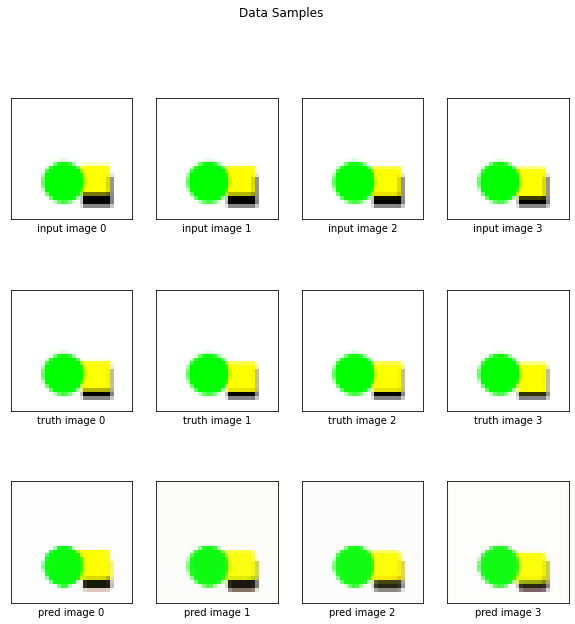

In [10]:
# showing sample results
t_data, t_segments = next(test_batch_generator)
pred_segments = model.predict(t_data, batch_size=cfg.BATCH_SIZE)
plot_sample_futureframepredictor_data_with_groundtruth(t_data, t_segments, pred_segments)

## EXERCISES

#### Exercise 1)
Update the network architecture given in the function **create_model** of the class PredictorDNNModel. Please note that the current image resolution is set to 32x32 (i.e. IMAGE_WIDTH and IMAGE_HEIGHT values) in the file configPredictor.py. 
This way initial experiements can run faster. Once you implement the inital version of the network, please set the resolution values back to 128x128. Experimental results should be provided for this high resolution images.  

**Hint:** You can add more ConvLSTM layers etc. Batch normalization and dropout are other options to be considered. You can also try applying different activation functions.

#### Exercise 2) 
Use different **optimization** (e.g. ADAM, SGD, etc) and **regularization** (e.g. data augmentation, dropout) methods to increase the network accuracy. 